# Visualising Collection Emotion
**Using the [NXC Sentiment API](https://api.nxc.io/docs) to visualise how Twitter feels about a contentious project**

## Set-up
- You need to set some variables, and install some libraries to run this example locally
- You can grab the external libraries we use for this example with `pip install -r requirements.txt`
#### WARNING
**For public and private wallet addresses, it's recommended that you load them through your local environment with `export VAR=xxx`, instead of pasting directly into this notebook**

In [1]:
# imports
import os
import json
import web3
import requests

# sensitive variables; if you paste directly into jupyter, don't push this notebook!
PUBLIC_ADDRESS=os.getenv("NXC_PUBLIC_ADDRESS", "") # the public address of the owner of the NXC Sentiment Alpha pass
PRIVATE_KEY=os.getenv("NXC_PRIVATE_KEY", "") # the private key to the above wallet
NXC_URL="https://alpha.api.nxc.io"


## Step 1: Getting an API acceess token
- You need a [NXC Sentiment Alpha Pass](https://opensea.io/collection/nxc-sentiment-api-alpha) to generate the token you'll use to sign requests to and from the endpoint. 
- Once you have one, you can generate a JWT (APU Access Token) using our `auth` endpoint

#### Getting the nonce for the transaction our wallet must sign

In [2]:
request_headers={"Accept" : "application/json", "Content-Type" : "application/json"}
request_params ={"publicAddress" : PUBLIC_ADDRESS}
response = requests.post(
    NXC_URL + "/auth/nonce",
    headers=request_headers, 
    json=request_params
) 
assert response.status_code == 200, "Something went wrong, double check your wallet address!"

# unpacking the response
nonce = json.loads(response.text)['nonce']
print(f"Nonce: {nonce}")

Nonce: 171158


#### Signing the nonce using the web3 library and our private key

In [3]:
from web3.auto import w3
from eth_account.messages import encode_defunct

# sign a message using our private key
signature= w3.eth.account.sign_message(
    encode_defunct(text=nonce),
    private_key=PRIVATE_KEY
)

# send the signed message to the sign-in endpoint
request_params = {
    "publicAddress" : PUBLIC_ADDRESS,
    "signature" : str(signature.signature.hex())
}
response = requests.post(
    NXC_URL + "/auth/signin",
    json=request_params
)
assert response.status_code==200, "Something went wrong, double check your private key!"
api_token = json.loads(response.text)['token']

## Step 2: Accessing the sentiment endpoint
- Your api access token will be good for 24 hours before you need to reauthenticate.
- Our endpoints will let you know when your token has expired

For this example, we'll check out the 24-hour twitter sentiment for [WZRDs](https://opensea.io/collection/wzrds), a contentious project as of 7/12/2022

In [4]:
collection_address="0xe5e771bc685c5a89710131919c616c361ff001c6" # the address for wzrds

In [5]:
headers = {"authorization" : f"Bearer {api_token}"}
response = requests.get(
    NXC_URL + "/collections/" + collection_address + "/sentiments/tweets",
    params ={"period" : "1d"},
    headers = headers
)
from pprint import pprint
assert response.status_code == 200, "Something went wrong. Check your access token!"
data = json.loads(response.text)

## Step 3: Visualising the data with Matplotlib and Seaborn
Now that we've got our data, let's create a pie-chart showing the past 24h twitter sentiment for WZRDs

In [6]:
# Here's the data we have to work with
from pprint import pprint
pprint([x for x in data.keys()])

['tweetsCount',
 'averageSentimentPolarity',
 'averageAdjustedSentimentPolarity',
 'modalSentimentCategory',
 'modalEmotionCategory',
 'emotionClassificationCount',
 'tweetIds']


In [44]:
%matplotlib inline

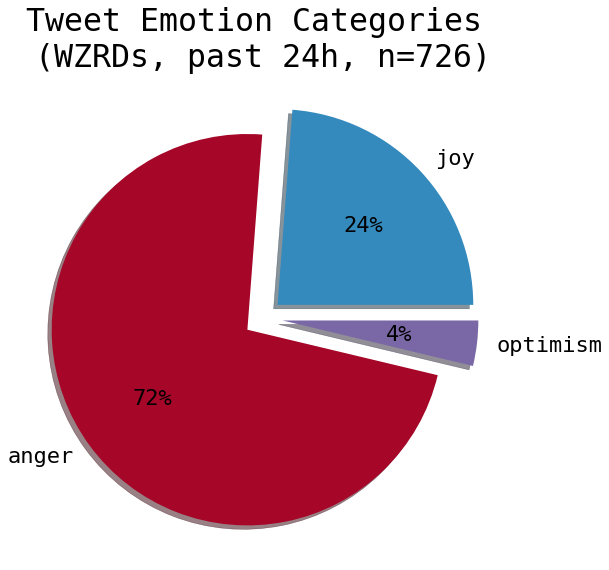

In [15]:
import matplotlib
import matplotlib.pyplot as plt

# emotions first
emotions = data['emotionClassificationCount']
total_impressions = sum(int(v) for v in emotions.values())

# we only want categories that make up at least 2% of the total values
values_to_plot = {
    k: int(v) for k, v in emotions.items()
    if (100 * int(v)//total_impressions) >= 2
}

labels = list(values_to_plot.keys())
values = list(values_to_plot.values())

# matplotlib settings
fig = plt.figure(
    figsize=(16,9),
    facecolor="white",
)
matplotlib.rc('font', **{'family' : 'monospace', 'size' : 22})
plt.style.use('bmh')
plt.pie(values, labels=labels, autopct='%.0f%%', explode=(0.1, 0.1, 0.1), shadow=True)
plt.title(f"Tweet Emotion Categories \n(WZRDs, past 24h, n={total_impressions})")
plt.savefig("wzrds-24h.png", dpi=120)